In [3]:
%matplotlib inline
import torch
from matplotlib_inline import backend_inline
from matplotlib import pyplot as plt


def use_svg_display(): #@save
    """svg"""
    backend_inline.set_matplotlib_formats('svg')

## figure size
def set_figsize(figsize=(3.5, 2.5)): #@save
    """matplotlib figuresize"""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize
    
## get the figure axis
#@save
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set matplotlib Axis"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()


def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """绘制数据点图形"""
    if legend is None:
        legend = []
    
    set_figsize(figsize)
    axes = axes if axes else plt.gca()
    
    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    
    if len(X) != len(Y):
        X = X * len(Y)
        axes.cla()
    
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
    
    return axes

def has_one_axis(X):
    """判断数据是否有一个轴"""
    return hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list) and not hasattr(X[0], "__len__")


C:\Users\gostj\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 20989 (\N{CJK UNIFIED IDEOGRAPH-51FD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\gostj\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


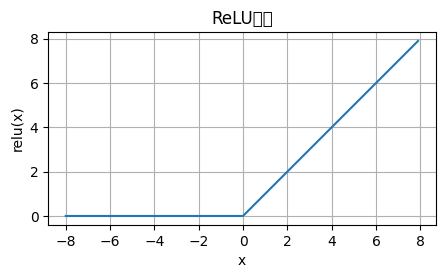

In [5]:
%matplotlib inline
import torch
import matplotlib.pyplot as plt

# 定义输入范围为-8到8之间的张量
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)

# 计算ReLU函数的输出
y = torch.relu(x)

# 创建图形，并指定大小
plt.figure(figsize=(5, 2.5))

# 绘制ReLU函数的图像
plt.plot(x.detach(), y.detach(), '-')

# 添加x轴和y轴标签
plt.xlabel('x')
plt.ylabel('relu(x)')

# 添加标题
plt.title('ReLU函数')

# 添加网格线
plt.grid(True)

# 显示图形
plt.show()


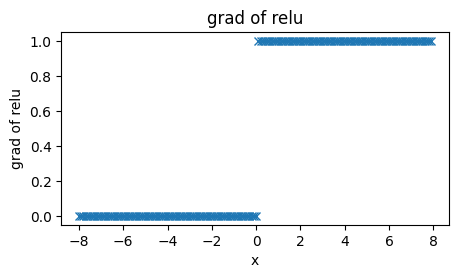

In [11]:
# 定义输入范围为-8到8之间的张量
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)

# 计算ReLU函数的输出
y = torch.relu(x)

# 对y进行反向传播，计算梯度
y.backward(torch.ones_like(x), retain_graph=True)

# 创建图形，并指定大小
plt.figure(figsize=(5, 2.5))

# 绘制ReLU函数的图像
plt.plot(x.detach(), x.grad, 'x')

# 添加x轴和y轴标签
plt.xlabel('x')
plt.ylabel('grad of relu')

# 添加标题
plt.title('grad of relu')

# 显示图形
plt.show()